# Sampling with q-space geodesic ODE Solver

In [1]:
## import libararies
import numpy as np
import torch

from scipy.spatial.distance import cdist, pdist
import scipy

import os
import ase.io
import ase
import sys
import copy

from torch_scatter import scatter_add

from lst_interp import *
import tqdm

import matplotlib.pyplot as plt
# import seaborn as sns

import sys
sys.path.append("/home/share/DATA/NeuralOpt/Interpolations/Geodesic_interp")
# from get_geodesic_energy import get_rijlist_and_re, compute_wij, morse_scaler
from get_geodesic_energy import morse_scaler, ATOMIC_RADIUS

/home/jhwoo/.conda/envs/pysis-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Experiment setting : random seed, precision, device
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    return
set_seed(0)
torch.set_default_dtype(torch.float64)
torch.set_num_threads(4)

# torch.set_default_dtype(torch.float32)
# torch.set_default_dtype(torch.float64)
torch.set_printoptions(linewidth=300)

In [31]:
atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz")); print("Load TS(wb97xd3) as X_0")
# atoms_T = list(ase.io.iread("pm7/pm7_rxn_ts.xyz")); print("Load TS(PM7) as X_T")
atoms_T = list(ase.io.iread("wb97xd3_geodesic/wb97xd3_geodesic_rxn_ts.xyz")); print("Load TS(geodesic) as X_T")

Load TS(wb97xd3) as X_0
Load TS(geodesic) as X_T


In [5]:
## wrapper class to save atoms object
from time import time
def timer(func):
    """Check time.

    Usage)
    >>> @timer
    >>> def method1(...):
    >>>     ...
    >>>     return
    """

    def wrapper(*args, **kwargs):
        start = time()
        result = func(*args, **kwargs)
        end = time()
        print(f"Elapsed time[{func.__name__}]: {end - start} sec", flush=True)
        return result
        return func(*args, **kwargs)

    return wrapper

class Wrapper:
    def __init__(
        self,
        atoms_0,
        atoms_T,
        q_type="DM",
        alpha=1.7,
        beta=0.01,
        gamma=0.01,
        using_jacobian=True,
        svd_tol=1e-4,
        noise_svd_tol=1e-2,
        verbose=False,
    ):
        self.atoms_0 = atoms_0
        self.atoms_T = atoms_T
        # assert q_type in ["DM", "morse"]
        self.q_type = q_type
        self.svd_tol = svd_tol
        self.re = torch.Tensor(self.get_re(atoms_T))
        self.alpha, self.beta = alpha, beta
        self.gamma = gamma
        self.morse_scaler = morse_scaler(self.re, self.alpha, self.beta)
        self.scaler_factor = 1.0
        self.using_jacobian = using_jacobian
        self.verbose = verbose
        self.noise_svd_tol = noise_svd_tol
        return

    def get_re(self, atoms, threshold=np.inf):
        from scipy.spatial import KDTree

        rijset = set()
        tree = KDTree(atoms.positions)
        pairs = tree.query_pairs(threshold)
        rijset.update(pairs)
        rijlist = sorted(rijset)

        radius = np.array([ATOMIC_RADIUS.get(atom.capitalize(), 1.5) for atom in atoms.get_chemical_symbols()])
        re = np.array([radius[i] + radius[j] for i, j in rijlist])
        return re

    # @timer
    def calc_jacobian(self, pos, q_type):
        # pos = Tensor, (N, 3)
        edge_index, edge_length = self.pos_to_dist(pos)
        distance = pdist(pos)
        distance_e = self.get_re(self.atoms_T)

        jacobian = []
        for i_idx in range(len(pos)):
            j_idx = list(range(len(pos)))
            j_idx.remove(i_idx)
            j_idx = torch.LongTensor(j_idx)

            j_mask = torch.any(edge_index == i_idx, axis=0)
            dd_dx = torch.zeros(size=(len(edge_length), 3))
            dq_dx = torch.zeros(size=(len(edge_length), 3))
            pos_i = pos[i_idx].reshape(1, -1)
            pos_j = pos[j_idx]

            dist = distance[j_mask].reshape(-1, 1)
            dd_dx[j_mask] += (pos_i - pos_j) / dist

            if q_type == "DM":
                jacobian.append(dd_dx.T)

            elif q_type == "morse":
                dq_dd = - (self.alpha / distance_e[j_mask]) * np.exp(-self.alpha * (distance[j_mask] - distance_e[j_mask]) / distance_e[j_mask])
                dq_dd -= self.beta * distance_e[j_mask] / (distance[j_mask] ** 2)
                dq_dx[j_mask] += dd_dx[j_mask] * dq_dd.reshape(-1, 1)
                jacobian.append(dq_dx.T)
                
            elif q_type == "morese+DM":
                raise NotImplementedError

        return torch.cat(jacobian, dim=0)
    
    # @timer
    def calc_distance_hessian(self, pos, edge_index, distance):
        N = len(pos)
        K = len(edge_index)
        hessian = torch.zeros(size=(K, 3 * N, 3 * N))
        for k, (ij, d_ij) in enumerate(zip(edge_index, distance)):
            i, j = ij
            pos_i, pos_j = pos[i], pos[j]

            # calculate hessian related to i, j atoms
            d_pos = pos_i - pos_j
            hess_ij = d_pos.reshape(1, -1) * d_pos.reshape(-1, 1)
            hess_ij /= d_ij ** 3
            hess_ij -= torch.eye(3) / d_ij
            
            # calculate hessian related to i, i atoms
            hess_ii = d_pos.reshape(1, -1) * d_pos.reshape(-1, 1)
            hess_ii /= - d_ij ** 3
            hess_ii += torch.eye(3) / d_ij
            
            # hess_ii = hess_jj
            hess_jj = hess_ii

            hessian[k, 3 * i:3 * (i + 1), 3 * i:3 * (i + 1)] += hess_ii
            hessian[k, 3 * j:3 * (j + 1), 3 * j:3 * (j + 1)] += hess_jj
            hessian[k, 3 * i:3 * (i + 1), 3 * j:3 * (j + 1)] += hess_ij
            hessian[k, 3 * j:3 * (j + 1), 3 * i:3 * (i + 1)] += hess_ij
            
        return hessian
    
    # @timer
    def calc_hessian(self, pos, q_type=None):
        if q_type is None:
            q_type = self.q_type
            
        edge_index, edge_length = self.pos_to_dist(pos)
        edge_index = edge_index.T
        distance = pdist(pos)
        distance_e = self.get_re(self.atoms_T)

        hessian = self.calc_distance_hessian(pos, edge_index, distance)
        
        if q_type == "DM":
            return hessian
        
        elif q_type == "morse":
            dq_dd = - self.alpha / distance_e * np.exp(-self.alpha * (distance - distance_e) / distance_e)
            dq_dd -= self.beta * distance_e / (distance ** 2)
            hessian_q = hessian * dq_dd.reshape(-1, 1, 1)
            
            for k, (ij, d_ij, de_ij) in enumerate(zip(edge_index, distance, distance_e)):
                i, j = ij
                pos_i, pos_j = pos[i], pos[j]
                # calculate hessian related to i, j atoms
                d_pos = pos_i - pos_j
                hess_ij = d_pos.reshape(1, -1) * d_pos.reshape(-1, 1)
                hess_ij /= - d_ij ** 2
                coeff = self.alpha ** 2 / de_ij ** 2 * np.exp(-self.alpha * (d_ij - de_ij) / de_ij)  + 2 * self.beta * de_ij / (d_ij ** 3)
                hess_ij *= coeff

                # calculate hessian related to i, i atoms
                hess_ii = - hess_ij
                
                hessian_q[k, 3 * i:3 * (i + 1), 3 * i:3 * (i + 1)] += hess_ii
                hessian_q[k, 3 * j:3 * (j + 1), 3 * j:3 * (j + 1)] += hess_ii
                hessian_q[k, 3 * i:3 * (i + 1), 3 * j:3 * (j + 1)] += hess_ij
                hessian_q[k, 3 * j:3 * (j + 1), 3 * i:3 * (i + 1)] += hess_ij
                
            return hessian_q
        
        elif q_type == "morese+DM":
            raise NotImplementedError
        return 
             
    def eq_transform(self, score_d, pos, edge_index, edge_length):
        if self.using_jacobian:
            jacobian = self.calc_jacobian(pos, q_type=self.q_type)
            
            score_pos = jacobian @ score_d.reshape(-1, 1)
            return score_pos.reshape(-1, 3)
            
        if self.q_type == "morse":
            edge_length = torch.Tensor(pdist(pos))
            
            N = pos.size(0)
            dd_dr = - (self.alpha / self.re) * torch.exp(-self.alpha * (edge_length - self.re) / self.re) / edge_length
            dd_dr -= self.beta * self.re / (edge_length ** 3)
            dd_dr = dd_dr.reshape(-1, 1)
            dd_dr = dd_dr * (pos[edge_index[0]] - pos[edge_index[1]])
            score_d = score_d.reshape(-1, 1)
            score_d *= self.scaler_factor
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        
        elif self.q_type == "DM":
            N = pos.size(0)
            dd_dr = (1.0 / edge_length).reshape(-1, 1) * (pos[edge_index[0]] - pos[edge_index[1]])
            score_d = score_d.reshape(-1, 1)
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        
        elif self.q_type == "morse+DM":
            edge_length = torch.Tensor(pdist(pos))
            N = pos.size(0)
            dd_dr = - (self.alpha / self.re) * torch.exp(-self.alpha * (edge_length - self.re) / self.re) / edge_length
            dd_dr -= self.beta * self.re / (edge_length ** 3)
            dd_dr += self.gamma / edge_length
            dd_dr = dd_dr.reshape(-1, 1)
            score_d *= self.scaler_factor
            dd_dr = dd_dr * (pos[edge_index[0]] - pos[edge_index[1]])
            score_d = score_d.reshape(-1, 1)
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        else:
            raise NotImplementedError
        return score_pos

    def pos_to_dist(self, pos, q_type=None):
        if q_type is None:
            q_type = self.q_type
        if q_type == "morse":
            rij = pdist(pos)
            wij = self.morse_scaler(rij)[0] * self.scaler_factor
            # print(wij, type(wij))
            # length = torch.Tensor(wij)
            length = wij
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        elif q_type == "DM":
            length = torch.Tensor(pdist(pos))
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        elif q_type == "morse+DM":
            rij = pdist(pos)
            wij = self.morse_scaler(rij)[0] * self.scaler_factor
            wij += self.gamma * rij
            length = torch.Tensor(wij)
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        else:
            raise NotImplementedError
        return index, length

    def reverse_diffusion_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True,
                                  using_jacobian=True, sampling_test=1, inner_iteration=5):
        beta_t = params.beta(t)

        if coord == "Cartesian":
            diff, coeff, v1, v2, v3, v4 = self.reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
            reverse_score_ = diff * coeff
            dw = torch.sqrt(beta_t * dt) * torch.randn_like(diff)
            dx = - 1.0 * reverse_score_ * dt + dw
        else:
            diff, coeff, v1, v2, v3, v4 = self.reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
            index, d_t = self.pos_to_dist(x_t)

            if sampling_test == 0:
                # every displacement is first calculated on the q-space, and then transformed to the Cartesian space
                reverse_score_ = diff * coeff
                dw = torch.sqrt(beta_t * dt) * torch.randn_like(diff)
                dd = - 1.0 * reverse_score_ * dt + dw

                dx = self.eq_transform(dd, x_t, index, d_t)
            
            elif sampling_test == 1:
                reverse_score_ = diff * coeff
                dw = torch.sqrt(beta_t * dt) * torch.randn_like(diff)
                dd = - 1.0 * reverse_score_ * dt + dw
                x_tm1 = self.exponential_ode_solver(x_t, -dd, q_type=self.q_type, num_iter=inner_iteration, check_dot_every=3)
                dx = - x_tm1 + x_t

            elif sampling_test == 2:
                reverse_score_ = diff * coeff
                # dw = torch.sqrt(beta_t * dt) * torch.randn_like(diff)
                # dd = - 1.0 * reverse_score_ * dt + dw
                dd = - 1.0 * reverse_score_ * dt
                x_tm1 = self.exponential_ode_solver(x_t, -dd, q_type=self.q_type, num_iter=inner_iteration, check_dot_every=3)
                dx = - x_tm1 + x_t

                ## Add noise
#                 # dw = torch.sqrt(beta_t * dt) * torch.randn_like(diff)
#                 dw = torch.sqrt(beta_t * dt) * torch.randn_like(dx)  # random noise in Cartensian coordinates
#                 print(f"Debug: Cartensian noise={dw}")

                jacob = self.calc_jacobian(x_t, q_type=self.q_type).T
                # U, S, Vh = self.svd(jacob)
                
                U, S, Vh = torch.svd(jacob)
                # num_zeros = (S < 1e-1).sum()
                num_zeros = (S < self.noise_svd_tol).sum()
                dim = len(S) - num_zeros
                S = S[:dim]
                U = U[:, :dim]
                Vh = Vh[:dim, :]
        
                # J = U @ torch.diag(S) @ Vh
                J_inv = Vh.T @ torch.diag(1 / S) @ U.T
                dw_q = U @ torch.randn(size=(U.shape[1],))
                dw_q *= torch.sqrt(beta_t * dt)
                dw_x = J_inv @ dw_q
                dw_x = dw_x.reshape(-1, 3)
                dw = dw_x
                # print(f"Debug: U.T @ U \n={U.T @ U}")
#                 print(f"Debug: x_t.shape={x_t.shape}")
#                 print(f"Debug: dw_x=\n{dw_x}")
#                 raise ValueError
                
                dx += dw

            elif sampling_test == 3:
                reverse_score_ = diff * coeff
#                 dw = torch.sqrt(beta_t * dt) * torch.randn_like(diff)
                
                jacob = self.calc_jacobian(x_t, q_type=self.q_type).T
                U, S, Vh = torch.svd(jacob)
                num_zeros = (S < self.noise_svd_tol).sum()
                # num_zeros = (S < 1e-10).sum()
                dim = len(S) - num_zeros
                S = S[:dim]
                U = U[:, :dim]
                Vh = Vh[:dim, :]
                J_inv = Vh.T @ torch.diag(1 / S) @ U.T
                dw = U @ torch.randn(size=(U.shape[1],))
                dw *= torch.sqrt(beta_t * dt) 

                dd = - 1.0 * reverse_score_ * dt + dw
                x_tm1 = self.exponential_ode_solver(x_t, -dd, q_type=self.q_type, num_iter=inner_iteration, check_dot_every=3)
                dx = - x_tm1 + x_t
                
                
        x_tm1 = x_t - dx
        return x_tm1, v1, v2, v3, v4

    def reverse_ode_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True,
                            using_jacobian=True, sampling_test=1, inner_iteration=5):
        beta_t = params.beta(t)

        if coord == "Cartesian":
            diff, coeff, v1, v2, v3, v4 = self.reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
            reverse_score_ = diff * coeff
            dx = - 0.5 * reverse_score_ * dt
            print(f"Debug ({t:0.3f}): \n\t1) diff norm and dx norm {diff.norm():0.4f}, {dx.norm():0.6f}")
        else:
            diff, coeff, v1, v2, v3, v4 = self.reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
            index ,d_t = self.pos_to_dist(x_t)

            if sampling_test == 0:
                reverse_score_ = diff * coeff
                dd = - 0.5 * reverse_score_ * dt
                dx = self.eq_transform(dd, x_t, index, d_t)                
                # Want to check why eq-transform does not work well
                diff_d = diff
                diff_x = self.eq_transform(diff_d, x_t, index, d_t)
                if self.verbose:
                    print(f"Debug ({t:0.3f}): \n\t1) diff-d norm and diff-x norm {diff_d.norm():0.4f}, {diff_x.norm():0.4f} \n\t2) dd-norm and dx-norm {dd.norm():0.6f}, {dx.norm():0.6f}")
                    print(f"\t3) dx-norm/dd-norm {dx.norm()/dd.norm():0.6f}")
                
            # elif sampling_test == 1:
            # elif sampling_test == 1 or sampling_test == 2:
            else:
                reverse_score_ = diff * coeff
                dd = - 0.5 * reverse_score_ * dt
                if self.verbose:
                    print(f"debug ] time : {t:0.3f}")
                    print(f"debug ] diff.norm() : {diff.norm()}")
                    print(f"debug ] dd.norm() : {dd.norm()}")
                x_tm1 = self.exponential_ode_solver(x_t, -dd, q_type=self.q_type, num_iter=inner_iteration, check_dot_every=3)
                dx = - x_tm1 + x_t
                if self.verbose:
                    print(f"debug ] dx.norm() : {dx.norm()}")
                
        x_tm1 = x_t - dx
        return x_tm1, v1, v2, v3, v4

    def reverse_score(self, x_t, t, params, x_0, x_T, verbose=True):
        # calculate parameters
        beta_t = params.beta(t)
        sigma_t_square = params.sigma_square(t)
        # sigma_T_square = params.sigma_1

        SNRTt = params.SNR(t)
        sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

        # calc mu_hat
        mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)

        # calc difference
        diff = mu_hat - x_t

        # calc_score    
        coeff =  1 / (sigma_t_hat_square) * beta_t
        score = diff * coeff
        
        # for debug
        if self.q_type == "DM":
        # if self.q_type in ["DM", "morse"]: # debugging # calculate err corresponding the metric
            _, d_T = self.pos_to_dist(x_T)
            _, d_t = self.pos_to_dist(x_t)
            _, d_0 = self.pos_to_dist(x_0)
            _, d_mu_hat = self.pos_to_dist(mu_hat)
            v1 = (d_mu_hat - d_t).abs().mean()
            # v2 = (d_mu_hat - d_T).abs().mean()
            v2 = (d_0 - d_t).abs().mean()
            v3 = (mu_hat - x_t.numpy()).abs().mean()
            v4 = (mu_hat - x_T.numpy()).abs().mean()
        # elif self.q_type == "morse":
        elif self.q_type in ["morse", "morse+DM", "Cartesian"]:
            version = "DMAE"
            # version = "Morse-RMSD"
            if version == "DMAE":
                d_T = torch.Tensor(pdist(x_T))
                d_mu_hat = torch.Tensor(pdist(mu_hat))  # typo=2의 경우, 이렇게 하면 안될 듯.
                d_t = torch.Tensor(pdist(x_t))
                d_0 = torch.Tensor(pdist(x_0))
                v1 = (d_mu_hat - d_t).abs().mean()
                # v2 = (d_mu_hat - d_T).abs().mean()
                v2 = (d_0 - d_t).abs().mean()
                v3 = abs(mu_hat - x_t.numpy()).mean()
                v4 = abs(mu_hat - x_T.numpy()).mean()
            else:
                _, d_T = self.pos_to_dist(x_T)
                _, d_mu_hat = self.pos_to_dist(mu_hat)  # typo=2의 경우, 이렇게 하면 안될 듯.
                _, d_t = self.pos_to_dist(x_t)
                _, d_0 = self.pos_to_dist(x_0)
                v1 = (d_mu_hat - d_t).norm()
                # v2 = (d_mu_hat - d_T).abs().mean()
                v2 = (d_0 - d_t).norm()
                v3 = abs(mu_hat - x_t.numpy()).mean()
                v4 = abs(mu_hat - x_T.numpy()).mean()
        else:
            raise NotImplementedError
        if verbose:
            print(f"{t:0.3f}\t{v1:0.4f}\t\t{v2:0.4f}\t\t{v3:0.4f}\t\t{v4:0.4f}\t\t{torch.linalg.norm(score, dim=-1).max():0.4f}")
        return diff, coeff, v1, v2, v3, v4

    # @timer
    def reverse_score2(self, x_t, t, params, x_0, x_T, verbose=True):
        # calculate parameters
        beta_t = params.beta(t)
        sigma_t_square = params.sigma_square(t)
        # sigma_T_square = params.sigma_1

        SNRTt = params.SNR(t)
        sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

        # calc mu_hat
        typo = 2
        
        if typo == 1:
            mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)
            _, d_mu_hat = self.pos_to_dist(mu_hat)
        if typo == 2:
            _, d_0 = self.pos_to_dist(x_0)
            _, d_T = self.pos_to_dist(x_T)
            d_mu_hat = d_T * SNRTt + d_0 * (1 - SNRTt)
            mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)  # for debugging
        if typo == 3:
            mu_hat = interpolate_LST(x_0.numpy(), x_T.numpy(), SNRTt.item())
            _, d_mu_hat = self.pos_to_dist(mu_hat)
        
        # calc difference
        index, d_t = self.pos_to_dist(x_t)
        diff_d = d_mu_hat - d_t
        diff = diff_d
        coeff =  1 / (sigma_t_hat_square) * beta_t

        # for debugging
        d_T = torch.Tensor(pdist(x_T))
        d_mu_hat = torch.Tensor(pdist(mu_hat))  # typo=2의 경우, 이렇게 하면 안될 듯.
        d_t = torch.Tensor(pdist(x_t))
        d_0 = torch.Tensor(pdist(x_0))
        v_loss_mae = (d_mu_hat - d_t).abs().mean()  # DMAE
        v_acc_mae = (d_0 - d_t).abs().mean()  # DMAE

        original_q_type = copy.deepcopy(self.q_type)
        self.q_type = "morse"
        _, d_T = self.pos_to_dist(x_T)
        _, d_mu_hat = self.pos_to_dist(mu_hat)  # typo=2의 경우, 이렇게 하면 안될 듯.
        _, d_t = self.pos_to_dist(x_t)
        _, d_0 = self.pos_to_dist(x_0)
        v_loss_norm = (d_mu_hat - d_t).norm()  # q-norm
        v_acc_norm = (d_0 - d_t).norm()  # q-norm
        self.q_type = original_q_type
        

        if verbose:
            print(f"{t:0.3f}\t{v_loss_mae:0.4f}\t\t{v_acc_mae:0.4f}\t\t{v_loss_norm:0.4f}\t\t{v_acc_norm:0.4f}\t")
        return diff, coeff, v_loss_mae, v_acc_mae, v_loss_norm, v_acc_norm
    
    # @timer
    def exponential_ode_solver(self, x0, q_dot0, q_type="morse", num_iter=100, check_dot_every=10):
#     def _exponential_ode_solver(self, x0, q_dot0, q_type="morse", num_iter=100, check_dot_every=10):
        
        t = torch.linspace(0, 1, num_iter + 1)[:-1]
        dt = t[1] - t[0]
#         t = torch.linspace(0, 1, num_iter)
#         dt = 1 / num_iter
        
        def one_step(x, x_dot, q_type=q_type, dt=dt, wrapper=self, refine_xdot=False):
            hess = wrapper.calc_hessian(x.reshape(-1, 3), q_type=q_type)
            jacob = wrapper.calc_jacobian(x.reshape(-1, 3), q_type=q_type).T
            
            J, J_inv = wrapper.refine_jacobian(jacob)
            JG = J_inv.T
            
            if refine_xdot:
                x_dot = J_inv @ J @ x_dot
            
            christoffel = torch.einsum("mij, mk->kij", hess, JG)
            x_ddot = - torch.einsum("j,kij,i->k", x_dot, christoffel, x_dot)
            # x_ddot and x_dot should be perpendicular 
            q_ddot = J @ x_ddot
            q_dot = J @ x_dot
            # remove q_dot component from q_ddot
            # q_ddot -= (q_ddot * q_dot).sum() * q_dot / (q_dot * q_dot).sum()
            # x_ddot = J_inv @ q_ddot
            
            new_x = x + x_dot * dt
            new_x_dot = x_dot + x_ddot * dt
            
            # dotproduct
            if self.verbose:
                print(f"\t\tdebug: <x_ddot, x_dot> = {(q_ddot * q_dot).sum()}")
                print(f"\t\tdebug: dx norm = {(new_x - x).norm():0.4f}, dx_dot norm = {(new_x_dot - x_dot).norm():0.4f}")
            return new_x, new_x_dot
        
        jacob = self.calc_jacobian(x0, q_type=q_type).T
        J, J_inv = self.refine_jacobian(jacob)
        
        # debugging
        if self.verbose:
            proj_q_dot = J @ J_inv @ q_dot0
            print(f"\tdebug: proj_q_dot norm = {(proj_q_dot - q_dot0).norm()/ q_dot0.norm():0.4f}")
        
        # initialization
        x_dot0 = J_inv @ q_dot0
        if self.verbose:
        # if True:
            # Debugging: q_dot0, x_dot0 크기 비교.
            print(f"Debug: x_dot0/q_dot0={x_dot0.norm()/q_dot0.norm()}, x_dot0.norm()={x_dot0.norm()}, q_dot0.norm()={q_dot0.norm()}")
        x = x0.flatten()
        x_dot = x_dot0
        
        # solve the geodesic ODE iteratively
        for i, t_i in enumerate(t):
            do_refine = i % check_dot_every == 0
            x, x_dot = one_step(x, x_dot, q_type=q_type, dt=dt, wrapper=self, refine_xdot=do_refine)
        return x.reshape(-1, 3)
    
    
    def svd(self, jacob):
        U, S, Vh = torch.linalg.svd(jacob)
        if self.verbose:
        # if True:
            print(f"Debug: Singular values = {S}")
        num_zeros = (S < self.svd_tol).sum()
        dim = len(S) - num_zeros
        S = S[:dim]
        U = U[:, :dim]
        Vh = Vh[:dim, :]
        if self.verbose:
        # if True:
            print(f"\t\t\tdebug: dim = {dim}, num_zeros = {num_zeros}")
        return U, S, Vh

    def refine_jacobian(self, jacob):
        # find non-zero singular values
        U, S, Vh = self.svd(jacob)
        J = U @ torch.diag(S) @ Vh
        J_inv = Vh.T @ torch.diag(1 / S) @ U.T
        return J, J_inv
        
#     def exponential_ode_solver(self, x0, q_dot0, q_type="morse", num_iter=100, check_dot_every=10, thresh=1e-2, max_dt=1e-1, verbose=False):
    def _exponential_ode_solver(self, x0, q_dot0, q_type="morse", num_iter=100, check_dot_every=10, thresh=1e-2, max_dt=1e-1, verbose=False):
        
        def one_step(x, x_dot, q_type=q_type, dt=1e-2, wrapper=self, refine_xdot=False, verbose=False):
            hess = wrapper.calc_hessian(x.reshape(-1, 3), q_type=q_type)
            jacob = wrapper.calc_jacobian(x.reshape(-1, 3), q_type=q_type).T
            
            # J, J_inv = wrapper.refine_jacobian(jacob)
            J = jacob
            J_inv = torch.linalg.pinv(J, rtol=1e-4, atol=1e-2)

            JG = J_inv.T
            if refine_xdot:
                x_dot = J_inv @ J @ x_dot
                if verbose:
                    print(f"\t\t\tdebug: x_dot norm = {x_dot.norm():0.6f}")
            christoffel = torch.einsum("mij, mk->kij", hess, JG)
            x_ddot = - torch.einsum("j,kij,i->k", x_dot, christoffel, x_dot)
            
            # x_ddot and x_dot should be perpendicular 
            q_ddot = J @ x_ddot
            q_dot = J @ x_dot
            
            new_x = x + x_dot * dt
            new_x_dot = x_dot + x_ddot * dt
            
            # dotproduct
            if verbose:
                print(f"\t\tdebug: <x_ddot, x_dot> = {(q_ddot * q_dot).sum()}")
                print(f"\t\tdebug: <x_ddot, x_dot> = {((jacob.T @ jacob) @ x_dot.reshape(-1, 1) * x_ddot).sum()}")
                print(f"\t\tdebug: x_dot size = {x_dot.norm():0.8f}, x_ddot size = {x_ddot.norm():0.8f}")
                print(f"\t\tdebug: dx norm = {(new_x - x).norm():0.8f}, dx_dot norm = {(new_x_dot - x_dot).norm():0.8f}")
            return new_x, new_x_dot

        
        jacob = self.calc_jacobian(x0, q_type=q_type).T
        # J, J_inv = self.refine_jacobian(jacob)
        J = jacob
        J_inv = torch.linalg.pinv(J, rtol=1e-4, atol=self.svd_tol)

        # debugging
        proj_q_dot = J @ J_inv @ q_dot0
        if verbose >= 1:
            print(f"\tdebug: proj_q_dot norm = {proj_q_dot.norm():0.4f}")
            print(f"\tdebug: proj_q_dot norm-ratio = {(proj_q_dot - q_dot0).norm()/ q_dot0.norm():0.4f}")
        
        # initialization
        x_dot0 = J_inv @ q_dot0
        x = x0.flatten()
        x_dot = x_dot0

        total_time = x_dot.norm()
        x_dot = x_dot / x_dot.norm()
        
        q = self.pos_to_dist(x.reshape(-1, 3))[1]
        # make time grid, 0 ~ total_time.
        # time spacing should be smaller than 1e-2
        # thresh = 5e-2
        # thresh = 1e-1
        # if total_time > num_iter * thresh:
        #     num_iter = int(total_time / thresh)
        
        # t = torch.linspace(0, total_time, num_iter + 1)[:-1]
        # # t = torch.linspace(0, 1, num_iter + 1)[:-1]
        # dt_ = t[1] - t[0]
        # dt = dt_
        # print(f"\tdebug: x_dot0.norm() = {x_dot0.norm()}")
        # print(f"\tdebug: x_dot0.norm() = {total_time.item():0.6f}")
        # solve the geodesic ODE iteratively
        # for i, t_i in enumerate(t):
        
        dt_ = min(total_time / num_iter, thresh)
        dt = dt_
        if verbose >= 1:
            print(f"initial dt = {dt_:0.6f}, total_expected_iter = {total_time / dt_:1.0f}")
            
        if verbose == 1:
            print("Progress-bar\n0%[--------------------]100%")
            print("0%[", end="")
        current_time = 0
        iter = 0
        cnt = 0
        total_dq = 0
        while total_time > current_time:
            # do_refine = i % check_dot_every == 0
            do_refine = False
            x_new, x_dot_new = one_step(x, x_dot, q_type=q_type, dt=dt, wrapper=self, refine_xdot=do_refine, verbose=verbose >= 3)
            current_time += dt
            
            # calculate dq
            q_new = self.pos_to_dist(x_new.reshape(-1, 3))[1]
            dq = (q_new - q).norm()
            total_dq += dq
            q = q_new
            if verbose >= 2:
                if iter % 25 == 0:
                    print(f"\tdebug: time = ({(current_time / total_time) * 100:0.4f}%), iter = {iter}, dt = {dt:0.6f}, dq = {dq:0.6f}")
            iter += 1
            
            x = x_new
            x_dot = x_dot_new
            # dt = x_dot.norm() * dt_
            dt = min(max(dt_, 1 / x_dot.norm() * dt_), max_dt)
            if current_time / total_time > cnt / 10 and verbose == 1:
                print(f"--", end="")
                cnt += 1
            if total_time - current_time < dt:
                dt = total_time - current_time
        # for i, t_i in enumerate(t):
        #     print(f"\tdebug: time = {t_i:0.4f} ({i/len(t) * 100:0.2f}%)")
        #     # do_refine = i % check_dot_every == 0
        #     do_refine = False
        #     x, x_dot = one_step(x, x_dot, q_type=q_type, dt=dt, wrapper=self, refine_xdot=do_refine)
        if verbose == 1:
            print("]100%")
#         return x.reshape(-1, 3), iter, total_dq
        return x.reshape(-1, 3)

---
# New SamplingParams class Test

In [6]:
class SamplingParams:
    def __init__(
        self,
        sampling_type,
        beta_std=0.125,
        sigma_max=1e-1,
        sigma_min=1e-7,
        order=None,
    ):
        assert sampling_type in ["bell-shaped", "monomial"]
        self.sampling_type = sampling_type
        self.sigma_max = sigma_max
        self.sigma_min = sigma_min
        self.beta_std = beta_std
        self.order = order
        print(f"Debug: sampling_type = {sampling_type}")
        print("Debug: std_beta, sigma_max, sigma_min, order = ", beta_std, sigma_max, sigma_min, order)
        return

    def beta(self, t):
        if self.sampling_type == "monomial":
            b = (self.order + 1) * self.sigma_max * (t ** self.order)
        elif self.sampling_type == "bell-shaped":
            b = torch.exp(-((t - 0.5) / self.beta_std) ** 2 / 2)
            normalizer = 1 / (self.beta_std * np.sqrt(2 * np.pi))
            b *= normalizer
            b *= self.sigma_max
        else:
            raise NotImplementedError
        return b

    def sigma_square(self, t):
        if self.sampling_type == "monomial":
            s_sq = self.sigma_max * (t ** (self.order + 1)) + self.sigma_min
        elif self.sampling_type == "bell-shaped":
            erf_scaler = self.sigma_max / 2
            s_sq = erf_scaler * (torch.special.erf((t - 0.5) / (np.sqrt(2) * self.beta_std)) - scipy.special.erf((0 - 0.5) / (np.sqrt(2) * self.beta_std)))
            s_sq += self.sigma_min
        else:
            raise NotImplementedError
        return s_sq

    def SNR(self, t):
        """
        return SNR(T) / SNR(t)
        """
        return self.sigma_square(t) / self.sigma_square(torch.ones(1))

Debug: sampling_type = bell-shaped
Debug: std_beta, sigma_max, sigma_min, order =  0.125 0.001 2e-06 None


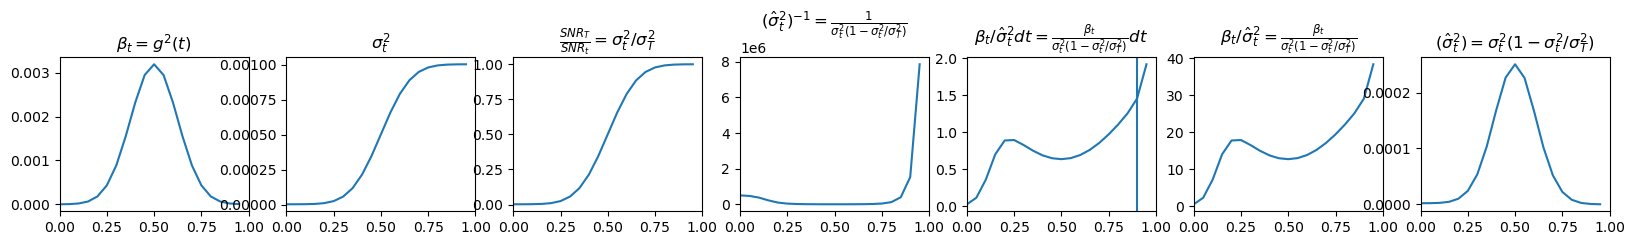

In [16]:
## Set sampling parameters
sampling_type = ["bell-shaped", "monomial"][0]

if sampling_type == "monomial":
    std_beta = None
    sigma_max = 0.01
    sigma_min = 5 * 1e-5
    sigma_min = 1e-6
#     sigma_min = 1e-4
    order = 2
#     order = 0.5
elif sampling_type == "bell-shaped":
    std_beta = 0.125
    sigma_max = 0.001
    sigma_min = 1e-6 * 2
    order = None
else:
    raise NotImplementedError

params = SamplingParams(
    sampling_type=sampling_type,
    beta_std=std_beta,
    sigma_max=sigma_max,
    sigma_min=sigma_min,
    order=order,
    )


## t samples
num_time_steps = 20
# num_time_steps = 100
t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
# t = torch.linspace(1e-2, 1, num_time_steps + 1)[:-1]
# t = torch.linspace(0, 0.9, num_time_steps + 1)[:-1]
betas = params.beta(t)
sigma_square = params.sigma_square(t)
SNRTt = params.SNR(t)


## plot
fig, axs = plt.subplots(1, 7, figsize=(20, 2))
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 10})  # Set the global font size to 12
axs = axs.flatten()

ax = axs[0];ax.plot(t, betas);ax.set_title(r"$\beta_t = g^2(t)$")
ax = axs[1];ax.plot(t, sigma_square);ax.set_title("$\sigma_{t}^{2}$")
ax = axs[2];ax.plot(t, SNRTt);ax.set_title(r"$\frac{SNR_{T}}{SNR_{t}}=\sigma_t^2/\sigma_T^2$")
ax = axs[3];ax.set_title(r"$(\hat{\sigma}_t^2)^{-1}=\frac{1}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$");ax.plot(t, (1 / sigma_square / (1 - SNRTt)))
ax = axs[4];ax.set_title(r"$\beta_t/\hat{\sigma}_{t}^2 dt=\frac{\beta_t}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)} dt$");ax.plot(t, (betas / sigma_square / (1 - SNRTt)) * 1 / len(betas))
ax.axvline(0.9)
ax = axs[5];ax.set_title(r"$\beta_t/\hat{\sigma}_{t}^2=\frac{\beta_t}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$");ax.plot(t, (betas / sigma_square / (1 - SNRTt)))
ax = axs[6];ax.set_title(r"$(\hat{\sigma}_t^2)={\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$");ax.plot(t, (1 * sigma_square * (1 - SNRTt)))
for ax in axs:
    ax.set_xlim(0, 1)

In [32]:
def experiment1(
    idx,
    sampling_type,
    coord_type,
    h_coeff=0.0,
    num_time_steps=200,
    verbose=False,
    plot=True,
    q_type="morse",
    sampling_test=1,
    atoms_0=atoms_0,
    atoms_T=atoms_T,
    inner_iteration=3,
    outer_iteration=None,
    svd_tol=1e-4,
    noise_svd_tol=1e-2,
    alpha=1.7,
    beta=0.01,
):
    set_seed(0)

    # find matched index
    xT = atoms_T[idx]
    file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
    gt_idx = int(file_name[2:])
    x0 = atoms_0[gt_idx]

    # Debugging: test add noise
    xT.set_positions(xT.positions + np.random.randn(*xT.positions.shape) * 0.02); print(f"add noise to xT")
    
    print(f"idx, gt_idx: {idx}, {gt_idx}")
    gamma = 0.0
    # alpha, beta = 1.7, 0.01
#     alpha, beta = 1.4, 0.6
    
    print(f"Debug: alpha, beta = {alpha}, {beta}")
    wrapper = Wrapper(x0, xT, q_type=q_type, alpha=alpha, beta=beta, gamma=gamma, using_jacobian=True, svd_tol=svd_tol, verbose=verbose, noise_svd_tol=noise_svd_tol)

    pos0 = torch.Tensor(x0.get_positions())
    posT = torch.Tensor(xT.get_positions())

    margin = 0.001
    # t = torch.linspace(0 + margin, 1 - 10 * margin, num_time_steps + 1)[:-1]
    t = torch.linspace(0 + margin, 0.9, num_time_steps + 1)[:-1]
    # t = torch.linspace(0 + margin, 0.7, num_time_steps + 1)[:-1]
    dt = (t[1:] - t[:-1]).mean()
    print(f"t-sampilng range: [{t[0], t[-1]}], dt={dt}")

    torch.set_printoptions(precision=6, sci_mode=False)
    reverse_traj = [posT]
    x = posT
    v1s = []
    v2s = []
    v3s = []
    v4s = []

    if verbose:
        print(f"(Debug) mu_d - d_t\t mu_d - d_T\t mu_x - x_t\t mu_x - x_T\t score")
    for idx, i in enumerate(torch.flip(t, dims=(0,))):
    # for idx, i in tqdm.tqdm(enumerate(torch.flip(t, dims=(0,))), total=len(t)):
        if sampling_type == "ode":
            x, v1, v2, v3, v4 = wrapper.reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose, sampling_test=sampling_test, inner_iteration=inner_iteration)
        else: # sde
            x, v1, v2, v3, v4 = wrapper.reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose, sampling_test=sampling_test, inner_iteration=inner_iteration)

        v1s.append(v1); v2s.append(v2); v3s.append(v3); v4s.append(v4)
        reverse_traj.append(x)
        
        if idx == outer_iteration: break

    return reverse_traj, v1s, v2s, v3s, v4s


def plot_traj(v, label="", ylabel=""): # r"||$\hat{d}_t - d_t$||"
    plt.plot(v, label=label)
    plt.xlabel(r"time step", fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend()
    return

In [23]:
"""
sampling_type: "sde", "ode"
coord_type: "Distance", "Morse"
"""

# num_time_steps = 100
num_time_steps = 20
# inner_iteration = 2
# inner_iteration = 5
# inner_iteration = 10
inner_iteration = 3
h_coeff = 0.0
verbose = [True, False][1]
q_type = ["DM", "morse"][1]
sampling_test = [0, 1][1]
sampling_test = 3
print(f"sampling_test={sampling_test}")
print(f"q_type = {q_type}")

svd_tol = 1e-10
noise_svd_tol = 1e-10
print(f"num_time_steps, inner_iteration, svd_tol, noise_svd_tol: {num_time_steps}, {inner_iteration}, {svd_tol}, {noise_svd_tol}")
# alpha, beta = 1.7, 0.01
alpha, beta = 1.6, 2.3


err_dct = dict()


import pickle
valid_indices = pickle.load(open("/home/share/DATA/NeuralOpt/data/data_split.pkl", "rb"))["valid_index"]
len(f"len(valid_indices): {valid_indices}")


for idx in range(50):
# for idx in [13,18,19,40,41,42,44]:
# for idx in valid_indices:
    err_at_zero_t = []
    reverse_traj, v1, v2, v3, v4 = experiment1(idx, "sde", "Distance", h_coeff, num_time_steps, 
                                               verbose=verbose, q_type=q_type, sampling_test=sampling_test,
                                               inner_iteration=inner_iteration, outer_iteration=250, svd_tol=svd_tol, noise_svd_tol=noise_svd_tol,
                                               alpha=alpha, beta=beta,)
    err_at_zero_t.append(v2[-1].item())
    plot_traj(v2[::-1], "sde-acc")
    plot_traj(v1[::-1], "sde-loss")
    reverse_traj, v1, v2, v3, v4 = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, 
                                               verbose=verbose, q_type=q_type, sampling_test=sampling_test, 
                                               inner_iteration=inner_iteration, outer_iteration=250, svd_tol=svd_tol, noise_svd_tol=noise_svd_tol,
                                               alpha=alpha, beta=beta,)
    err_at_zero_t.append(v2[-1].item())
    plot_traj(v2[::-1], "ode-acc")
    plot_traj(v1[::-1], "ode-loss")

    print("err_at_zero_t = ", err_at_zero_t)
    err_dct[idx] = err_at_zero_t
    
    plt.ylim(0,)
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
print("Done!")
print(err_dct)

sampling_test=3
q_type = morse
num_time_steps, inner_iteration, svd_tol, noise_svd_tol: 20, 3, 1e-10, 1e-10


AttributeError: module 'numpy.random' has no attribute 'randn_like'

# Equitransform (sampling_test=0) 다시 실험.

sampling_test=1
q_type = morse
num_time_steps, inner_iteration, svd_tol, noise_svd_tol: 20, 3, 1e-10, 1e-10
add noise to xT
idx, gt_idx: 42, 42
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 42, 42
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.08427617117172737, 0.10761151075101717]


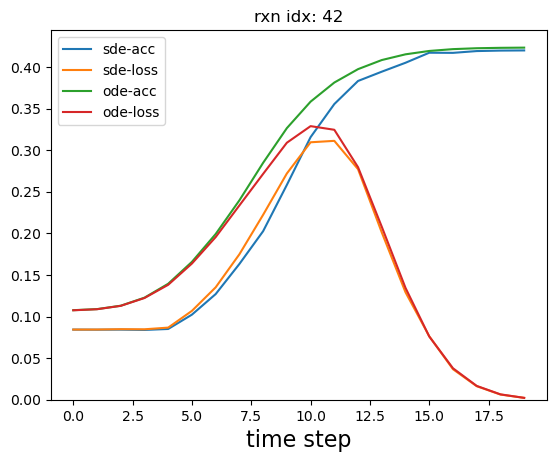

add noise to xT
idx, gt_idx: 3073, 3073
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 3073, 3073
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.1334421609192259, 0.13647899385952392]


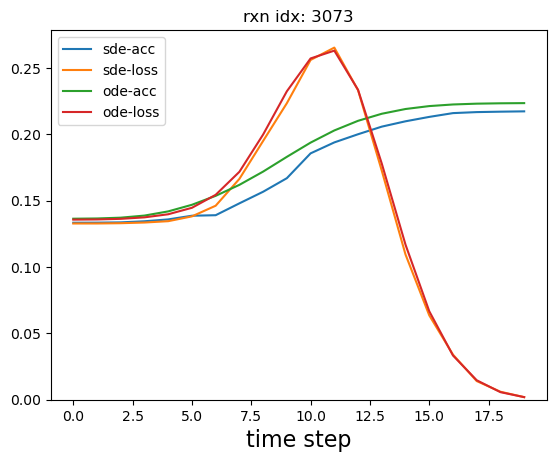

add noise to xT
idx, gt_idx: 3697, 3697
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 3697, 3697
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.1517043264829655, 0.15493847842325023]


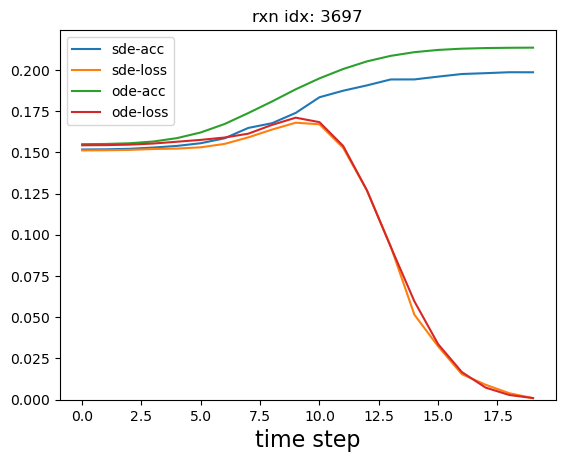

add noise to xT
idx, gt_idx: 3878, 3878
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 3878, 3878
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.10861929863626034, 0.1101040369752724]


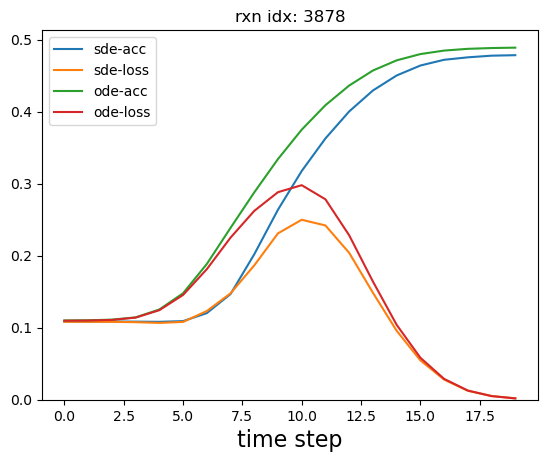

add noise to xT
idx, gt_idx: 3981, 3981
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 3981, 3981
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.15058889485552132, 0.18532739044439814]


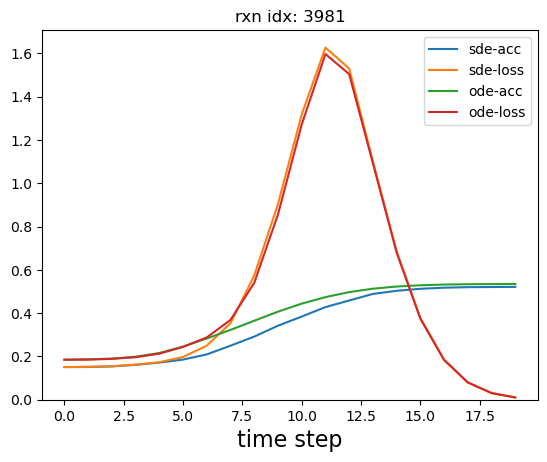

add noise to xT
idx, gt_idx: 4088, 4088
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 4088, 4088
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.19184697499470252, 0.18859525348990816]


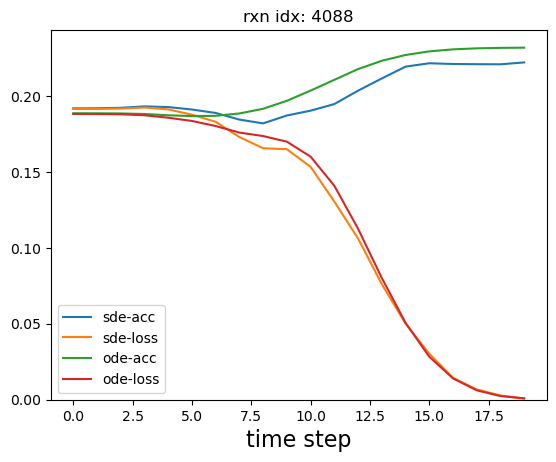

add noise to xT
idx, gt_idx: 4133, 4133
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 4133, 4133
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.18205756182571356, 0.18049658420869766]


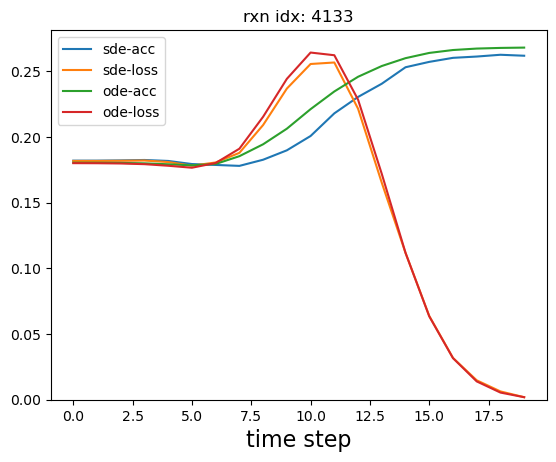

add noise to xT
idx, gt_idx: 5967, 5967
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 5967, 5967
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.3002779515686691, 0.304764059578878]


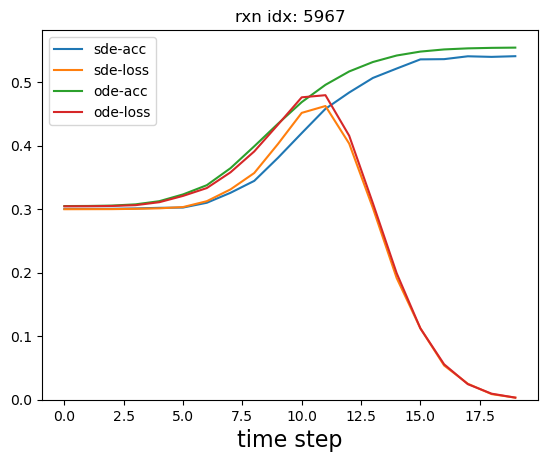

add noise to xT
idx, gt_idx: 6625, 6625
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 6625, 6625
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.022766113447189686, 0.16388570564155774]


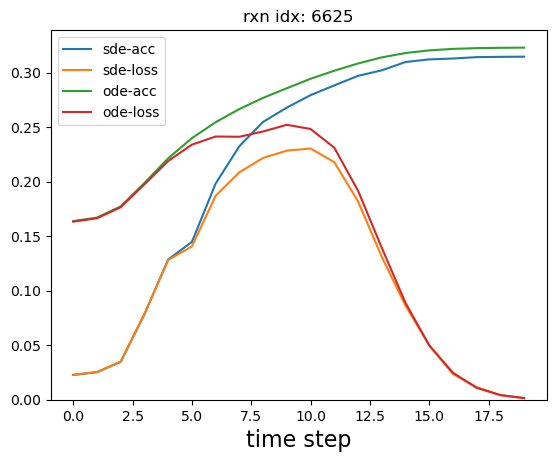

add noise to xT
idx, gt_idx: 7019, 7019
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 7019, 7019
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.21676850583714385, 0.21792850484097365]


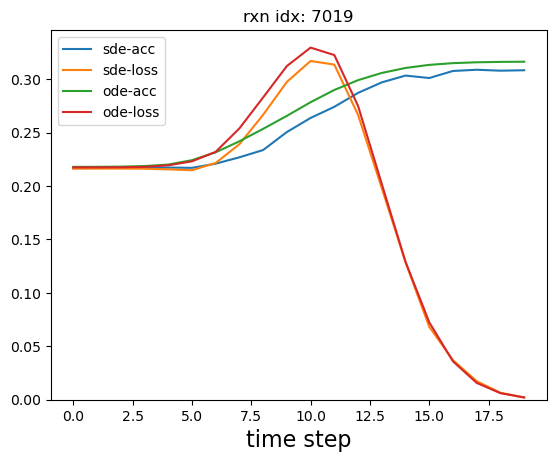

add noise to xT
idx, gt_idx: 7449, 7449
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 7449, 7449
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.017194954270679783, 0.1614025513729578]


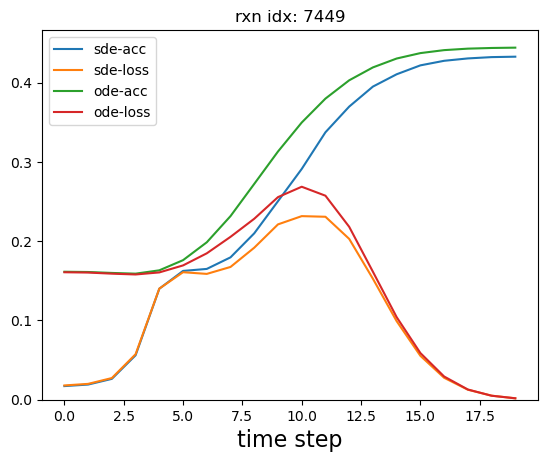

add noise to xT
idx, gt_idx: 9075, 9075
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 9075, 9075
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.13487218212416968, 0.1381864435520171]


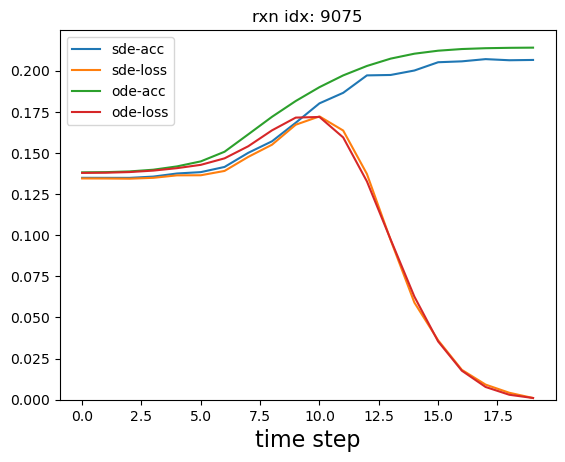

add noise to xT
idx, gt_idx: 9197, 9197
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 9197, 9197
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.1541508191369932, 0.15963279523568613]


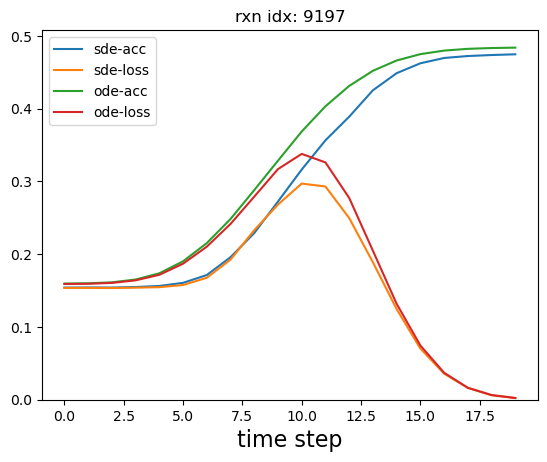

add noise to xT
idx, gt_idx: 9333, 9333
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 9333, 9333
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.1301044333016325, 0.1312844770066904]


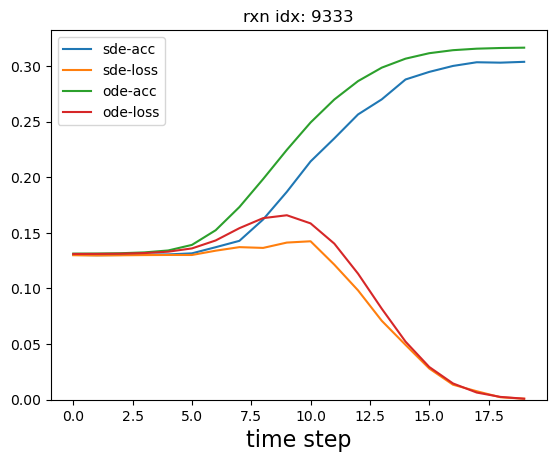

add noise to xT
idx, gt_idx: 9740, 9740
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 9740, 9740
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.12273349683059954, 0.12842562544023614]


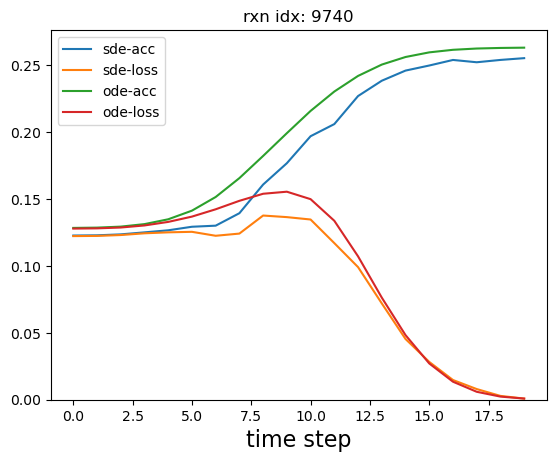

add noise to xT
idx, gt_idx: 10322, 10322
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 10322, 10322
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.12606281896384744, 0.16625849852568186]


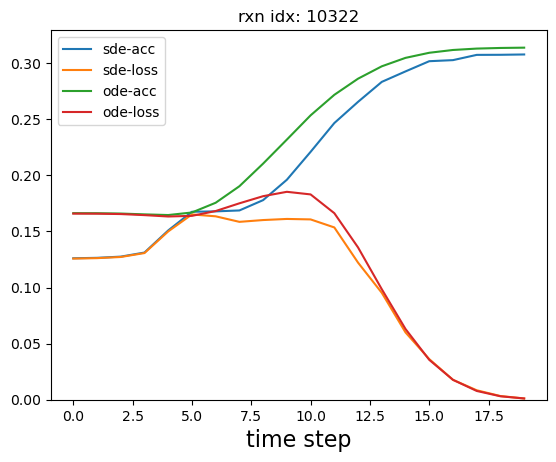

add noise to xT
idx, gt_idx: 10413, 10413
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 10413, 10413
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.1116693546525783, 0.12080328327314206]


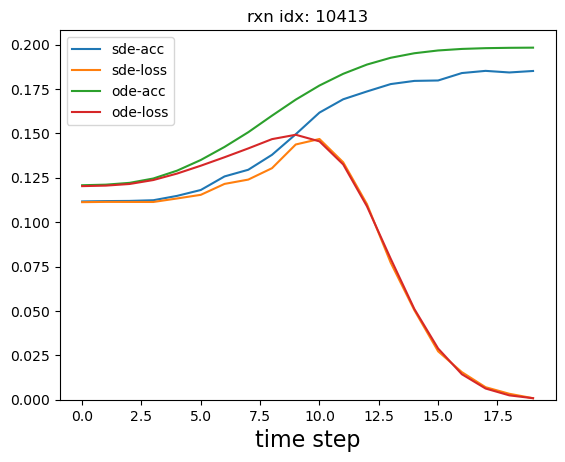

add noise to xT
idx, gt_idx: 10794, 10794
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 10794, 10794
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.020803759703582628, 0.12182806164543433]


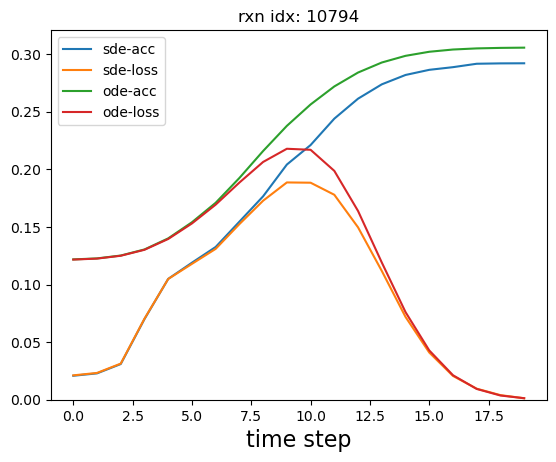

add noise to xT
idx, gt_idx: 11287, 11287
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
add noise to xT
idx, gt_idx: 11287, 11287
Debug: alpha, beta = 1.6, 2.3
t-sampilng range: [(tensor(0.001000), tensor(0.855050))], dt=0.04495
err_at_zero_t =  [0.12742916239816368, 0.14021004547792648]


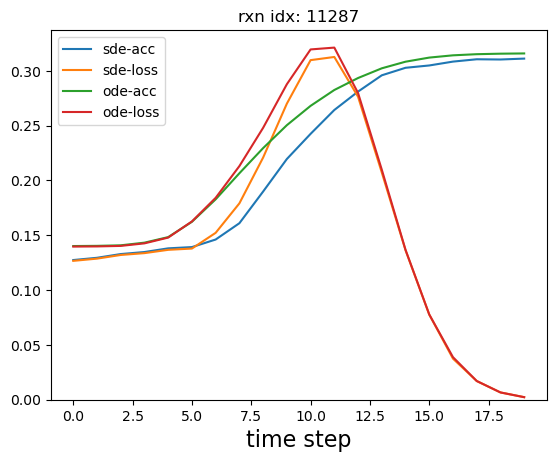

Done!
{42: [0.08427617117172737, 0.10761151075101717], 3073: [0.1334421609192259, 0.13647899385952392], 3697: [0.1517043264829655, 0.15493847842325023], 3878: [0.10861929863626034, 0.1101040369752724], 3981: [0.15058889485552132, 0.18532739044439814], 4088: [0.19184697499470252, 0.18859525348990816], 4133: [0.18205756182571356, 0.18049658420869766], 5967: [0.3002779515686691, 0.304764059578878], 6625: [0.022766113447189686, 0.16388570564155774], 7019: [0.21676850583714385, 0.21792850484097365], 7449: [0.017194954270679783, 0.1614025513729578], 9075: [0.13487218212416968, 0.1381864435520171], 9197: [0.1541508191369932, 0.15963279523568613], 9333: [0.1301044333016325, 0.1312844770066904], 9740: [0.12273349683059954, 0.12842562544023614], 10322: [0.12606281896384744, 0.16625849852568186], 10413: [0.1116693546525783, 0.12080328327314206], 10794: [0.020803759703582628, 0.12182806164543433], 11287: [0.12742916239816368, 0.14021004547792648]}


In [34]:
"""
sampling_type: "sde", "ode"
coord_type: "Distance", "Morse"
"""

# num_time_steps = 100
num_time_steps = 20
# num_time_steps = 30
# num_time_steps = 50
# inner_iteration = 2
# inner_iteration = 5
# inner_iteration = 10
# inner_iteration = 1
inner_iteration = 3
h_coeff = 0.0
verbose = [True, False][1]
q_type = ["DM", "morse"][1]
sampling_test = [0, 1][1]
sampling_test = 1
print(f"sampling_test={sampling_test}")
print(f"q_type = {q_type}")

svd_tol = 1e-10
noise_svd_tol = 1e-10
# svd_tol = 1e-2
# noise_svd_tol = 1e-2
print(f"num_time_steps, inner_iteration, svd_tol, noise_svd_tol: {num_time_steps}, {inner_iteration}, {svd_tol}, {noise_svd_tol}")
# alpha, beta = 1.7, 0.01
alpha, beta = 1.6, 2.3


err_dct = dict()


import pickle
valid_indices = pickle.load(open("/home/share/DATA/NeuralOpt/data/data_split.pkl", "rb"))["valid_index"]
len(f"len(valid_indices): {valid_indices}")

valid_indices = [13,18,19,40,41,42,44]
valid_indices = [2471, 3475, 9157, 10682] ## geodesix X_T에서 SDE 터진 케이스
valid_indices = [1169, 4061, 5590, 8702] ## PM7 X_T에서 ODE 터진 케이스
valid_indices = [42, 3073, 3697,3878,3981,4088,4133,5967,6625,7019,7449,9075,9197,9333,9740,10322,10413,10794,11287]  ## ode_err[ode_err > 0.1]

X_T_type = "PM7"
X_T_type = "geodesic"
if X_T_type == "PM7":
    from SamplingExperiment4 import find_matched_index
    valid_indices = find_matched_index(valid_indices)[0]


# for idx in range(50):
for idx in valid_indices:
    err_at_zero_t = []
    reverse_traj, v1, v2, v3, v4 = experiment1(idx, "sde", "Distance", h_coeff, num_time_steps, 
                                               verbose=verbose, q_type=q_type, sampling_test=sampling_test,
                                               inner_iteration=inner_iteration, outer_iteration=250, svd_tol=svd_tol, noise_svd_tol=noise_svd_tol,
                                               alpha=alpha, beta=beta,)
    err_at_zero_t.append(v2[-1].item())
    plot_traj(v2[::-1], "sde-acc")
    plot_traj(v1[::-1], "sde-loss")
    reverse_traj, v1, v2, v3, v4 = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, 
                                               verbose=verbose, q_type=q_type, sampling_test=sampling_test, 
                                               inner_iteration=inner_iteration, outer_iteration=250, svd_tol=svd_tol, noise_svd_tol=noise_svd_tol,
                                               alpha=alpha, beta=beta,)
    err_at_zero_t.append(v2[-1].item())
    plot_traj(v2[::-1], "ode-acc")
    plot_traj(v1[::-1], "ode-loss")

    print("err_at_zero_t = ", err_at_zero_t)
    err_dct[idx] = err_at_zero_t
    
    plt.ylim(0,)
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
print("Done!")
print(err_dct)